In [2]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from pyvis.network import Network
import numpy as np
from tqdm import tqdm
import random

from networkx.algorithms.centrality import edge_betweenness_centrality

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool


from scipy.cluster.hierarchy import dendrogram


%matplotlib inline

In [3]:
# Définir le chemin de base
base_path = Path('Dataset') / 'wikipedia' / 'chameleon'

# Charger les données
with (base_path / 'musae_chameleon_features.json').open('r') as f:
    features = json.load(f)

edges = pd.read_csv(base_path / 'musae_chameleon_edges.csv')
targets = pd.read_csv(base_path / 'musae_chameleon_target.csv')

names = pd.read_csv('data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

In [4]:
names[0][3]

'3 LyndonHochschildSerre spectral sequence'

In [5]:
edges.head()

,id1,id2
0,2034,1939
1,2034,2263
2,2034,1976
3,2034,2234
4,2034,804


In [6]:
targets.head()

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634


Text(0.5, 1.0, 'Graphe construit à partir des données fournies')

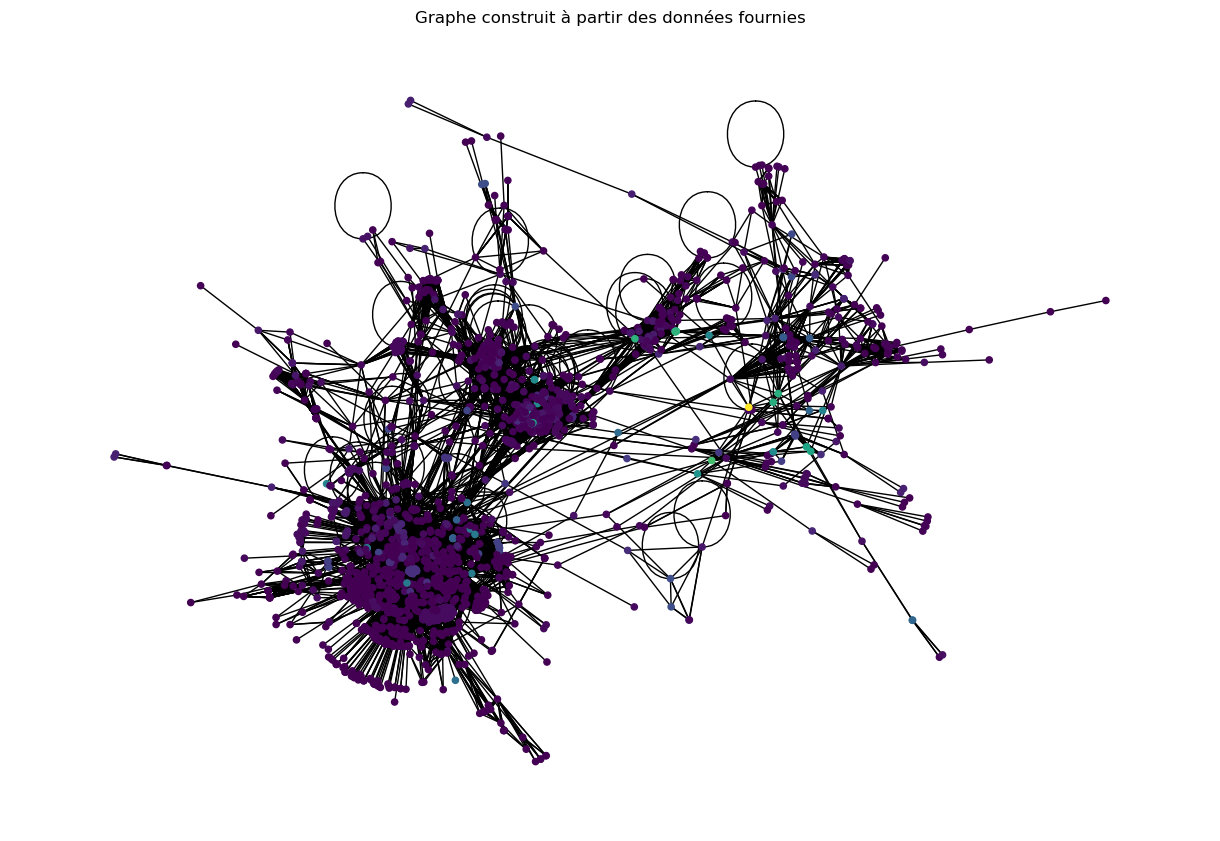

In [7]:
# Créer un graphe
G = nx.Graph()

# Ajouter les nœuds avec leurs attributs
for node, attrs in features.items():
    G.add_node(int(node), features=attrs)

# Ajouter les arêtes
for _, row in edges.iterrows():
    G.add_edge(row['id1'], row['id2'])

# Ajouter les cibles comme attributs des nœuds
for _, row in targets.iterrows():
    if int(row['id']) in G.nodes:
        G.nodes[int(row['id'])]['target'] = row['target']

# Tracer le graphe
plt.figure(figsize=(12, 8))
node_colors = [G.nodes[node].get('target', 0) for node in G.nodes]
nx.draw(
    G, 
    node_color=node_colors, 
    cmap=plt.cm.viridis, 
    node_size=20, 
    with_labels=False
)

plt.title("Graphe construit à partir des données fournies")

In [8]:
G.number_of_nodes(), G.number_of_edges()

(2277, 31421)

# Baseline

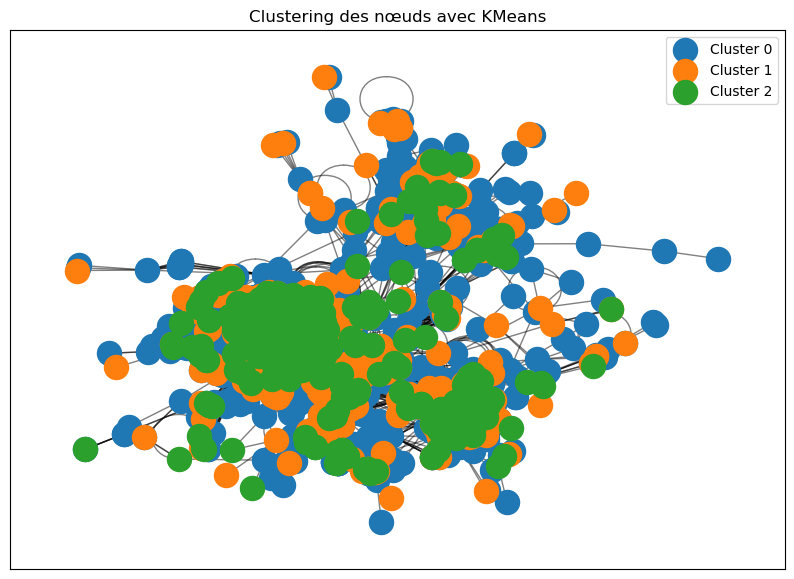

In [9]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

def graph_to_spectral_features(graph, num_features=2):
    """
    Convertit un graphe en une représentation spectrale.
    Arguments :
        graph : networkx.Graph
            Le graphe à analyser.
        num_features : int
            Nombre de composantes spectrales à conserver.
    Retourne :
        spectral_features : np.ndarray
            Une matrice où chaque ligne est une représentation spectrale d'un nœud.
    """
    # Matrice Laplacienne
    laplacian = nx.normalized_laplacian_matrix(graph).astype(float)
    
    # Calcul des vecteurs propres
    eigval, eigvec = eigs(laplacian, k=num_features, which='SM')  # 'SM' : Smallest Magnitude
    spectral_features = np.real(eigvec)  # On ne conserve que la partie réelle
    
    return spectral_features


def kmeans_on_graph(graph, num_clusters=3, num_features=2):
    """
    Applique KMeans sur les nœuds d'un graphe en utilisant une représentation spectrale.
    Arguments :
        graph : networkx.Graph
            Le graphe à analyser.
        num_clusters : int
            Nombre de clusters pour KMeans.
        num_features : int
            Nombre de composantes spectrales pour la représentation des nœuds.
    Retourne :
        labels : np.ndarray
            Un tableau contenant l'assignation de cluster pour chaque nœud.
    """
    # Étape 1 : Représentation spectrale
    spectral_features = graph_to_spectral_features(graph, num_features=num_features)
    
    # Étape 2 : KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(spectral_features)
    
    return labels


# Appliquer le clustering sur votre graphe G
num_clusters = 3  # Nombre de clusters à trouver
labels = kmeans_on_graph(G, num_clusters=num_clusters, num_features=2)

# Visualisation des résultats
pos = nx.spring_layout(G)  # Positionnement des nœuds pour la visualisation
plt.figure(figsize=(10, 7))
for cluster in range(num_clusters):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n, l in enumerate(labels) if l == cluster],
        node_size=300,  # Ajuster la taille des nœuds
        node_color=f"C{cluster}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {cluster}"
    )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds avec KMeans")
plt.show()

# Betweeness

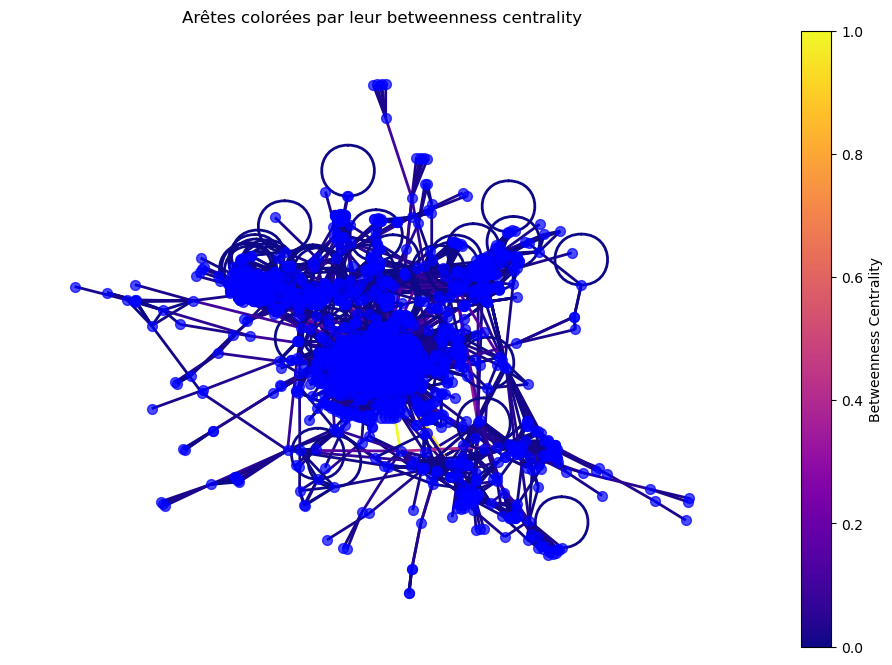

In [10]:
# test de l'approche betweeness sur un graphe


# Calcul de la betweenness centrality pour chaque arête
edge_betweenness = edge_betweenness_centrality(G)

# Normaliser les valeurs de betweenness pour la visualisation
max_betweenness = max(edge_betweenness.values()) if edge_betweenness else 1
edge_colors = [edge_betweenness[edge] / max_betweenness for edge in G.edges]

# Créer une figure et des axes explicites
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G)  # Calculer les positions des nœuds pour le tracé

# Tracer les nœuds
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color="blue", alpha=0.7)

# Tracer les arêtes avec des couleurs selon leur betweenness
edges = nx.draw_networkx_edges(
    G, pos, ax=ax, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=2
)

# Ajouter une colorbar en explicitant l'axe
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")

# Ajouter un titre et finaliser
ax.set_title("Arêtes colorées par leur betweenness centrality")
ax.axis("off")
plt.show()

In [11]:
def remove_edges_with_highest_betweenness(graph, num_edges=300, k=200):
    """
    Supprime les `num_edges` arêtes ayant la plus grande betweeness centrality,
    tout en recalculant la centralité après chaque suppression, et retourne les clusters.
    
    Arguments :
        graph : networkx.Graph
            Le graphe sur lequel effectuer la suppression.
        num_edges : int
            Nombre d'arêtes à supprimer.
        k : int
            Paramètre pour l'approximation de la centralité.
    
    Retourne :
        modified_graph : networkx.Graph
            Le graphe après suppression des arêtes.
        clusters_numpy : np.ndarray
            Les clusters convertis en un tableau NumPy.
    """
    graph = graph.copy()  # Travaillez sur une copie pour préserver l'original

    # Supprimer les arêtes avec la plus grande betweeness
    for _ in tqdm(range(num_edges), desc="Suppression des arêtes"):
        edge_betweenness = nx.edge_betweenness_centrality(graph, k=k)
        edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
        graph.remove_edge(*edge_to_remove)

    # Extraire les clusters à partir des composantes connectées
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters


def visualize_clusters(graph, clusters_numpy):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters_numpy : np.ndarray
            Tableau NumPy représentant les clusters.
    """
    pos = nx.spring_layout(graph, seed=42)  # Générer une disposition stable
    colors = plt.cm.get_cmap("tab10", len(clusters_numpy))  # Palette de couleurs pour les clusters
    
    plt.figure(figsize=(10, 7))

    # Dessiner les nœuds, colorés par cluster
    for i, cluster in enumerate(clusters_numpy):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=cluster,  # `cluster` est déjà une liste de nœuds
            node_size=300,
            node_color=[colors(i)],
            label=f"Cluster {i + 1}"
        )
    
    # Dessiner les arêtes restantes
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    
    plt.legend()
    plt.title("Clusters après suppression des arêtes")
    plt.show()



In [ ]:
G2,clusters = remove_edges_with_highest_betweenness(G)
# Visualiser les clusters
visualize_clusters(G2, clusters)

Suppression des arêtes:   4%|▍         | 13/300 [01:00<22:29,  4.70s/it]

In [ ]:
len(clusters)

5

In [ ]:
dictionary_clusters={}
for i in range(len(clusters)):
    liste=[]
    for j in clusters[i]:
        liste.append(names[0][j])
    dictionary_clusters[i] = liste


In [ ]:
from wordcloud import WordCloud

for cluster_id, cluster_phrases in dictionary_clusters.items():
    # Combinez toutes les phrases du cluster
    print(len(cluster_phrases))
    text = ' '.join(set(text.split()))
    print(f"Cluster {cluster_id} : {text[:100]}...")
    # Générez le Word Cloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    # Affichez le Word Cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

NameError: name 'dictionary_clusters' is not defined